# Defining and Visualizing fmdtools Model Structures

To ensure that a simulation meets the intent of a modeller, it is important to carefully define the structure of the model and run order. This notebook will demonstrate fmdtools' interfaces both for setting up model structures and the run order for better model development.

In [1]:
import sys
# for use in development - makes sure git version is used instead of pip-installed version
paths = sys.path
if paths[1]!='../':
    sys.path=[sys.path[0]] + ['../'] + paths

from fmdtools.modeldef import *
import fmdtools.resultdisp as rd
import fmdtools.faultsim.propagate as prop

### Basics

An fmdtools model is made up of functions--model structures with behavioral methods and internal states--and flows--data relationships between functions. These functions and flows are defined in python classes and thus may be instantiated multiple times in a model to create multi-component models with complex interactions. The structure of these model classes is shown below:

![Model Classes](files/figures/example_model.png)

Creating a model thus involves:
- defining the function and flow classes defining the behavior of the model in the model module
- defining the specific structure for the model: function and flow *objects* (instantiations of functions) and their relationships.

The main functions for viewing the model structure is `rd.graph.show`

In [2]:
help(rd.graph.show)

Help on function show in module fmdtools.resultdisp.graph:

show(g, gtype='normal', pos=[], scale=1, faultscen=[], time=[], showfaultlabels=True, highlight=[], colors=['lightgray', 'orange', 'red'], heatmap={}, cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x000002C8953EFB88>)
    Plots a single graph object g.
    
    Parameters
    ----------
    g : networkx graph or model
        The multigraph to plot
    gtype : 'normal' or 'bipartite'
        Type of graph input to show--normal (multgraph) or bipartite
    pos : dict
        Positions for nodes
    scale: float
        Changes sizes of nodes in bipartite graph
    faultscen : str, optional
        Name of the fault scenario (for the title). The default is [].
    time : float, optional
        Time of fault injection. The default is [].
    showfaultlabels : bool, optional
        Whether or not to label the faults on the functions. The default is True.
    highlight : list, optional
        Functions/flows to highl

However, these relationships only define the *structure* of the model--for the model to simulate correctly and efficiently, the run order of fuctions additionally must be defined.

Each timestep of a model simulation can be broken down into two steps: 

![Dynamic Propagation Step](files/figures/dynamic_step.png) 

- **Dynamic Propagation Step:** In the dynamic propagation step, the time-based behaviors (e.g. accumulations, movement, etc.) are each run *once* in a specified order. These steps are generally quicker to execute because each behavior is only run once and the flows do not need to be tracked to determine which behaviors to execute next. This step is run first at each time-step of the model.

![Static Propagation Step](files/figures/propogation.png)

- **Static Propagation Step:**
    In the static propagation step, behaviors are propagated between functions iteratively until the state of the model converges to a single value. This may require an update of multiple function behaviors until there are no more new behaviors to run. Thus, static behaviors should be ''timeless'' (always give the same output for the same input) and convergent (behaviors in each function should not change each other ad infinitum). This step is run second at each time-step of the model.

With these different behaviors, one can express a range of different types of models:
- **static models** where only only one timestep is run, where fault scenarios show the immediate propagation of faults through the system.
- **dynamic models** where a number of timesteps are run (but behaviors are only run once).
- **hybrid models** where dynamic behaviors are run once and then a static propagation step is performed at each time-step.

The main interfaces/functions involved in defining run order are:
- `FxnBlock.static_behavior(self, time)` and `FxnBlock.behavior(self, time)`, which define function behaviors which occur during the static propagation step. 
- `FxnBlock.dynamic_behavior(self, time)`, which defines function behaviors during the dynamic propagation step.
- `FxnBlock.condfaults(self, time)`, does not define run order, but it can be used for behaviors which would at any time during simulation (dynamic or static) lead to the system entering a fault mode (e.g., conditional faults).
- `Model.add_fxn()`, which when used successively for each function specifies that those functions run in the order they are added.

There is additionally `Model.build_model()`, which enables one to manually specify the order of the dynamic propagation step (and initial static step):

In [3]:
help(Model.build_model)

Help on function build_model in module fmdtools.modeldef:

build_model(self, functionorder=[], graph_pos={}, bipartite_pos={})
    Builds the model graph after the functions have been added.
    
    Parameters
    ----------
    functionorder : list, optional
        The order for the functions to be executed in. The default is [].
    graph_pos : dict, optional
        position of graph nodes. The default is {}.
    bipartite_pos : dict, optional
        position of bipartite graph nodes. The default is {}.



The overall static/dynamic propagation steps of the model can then be visualized using `rd.graph.exec_order`

In [4]:
help(rd.graph.exec_order)

Help on function exec_order in module fmdtools.resultdisp.graph:

exec_order(mdl, gtype='bipartite', pos=[], scale=1, colors=['lightgray', 'cyan', 'teal'], show_dyn_order=True, title='Function Execution Order', legend=True)
    Displays the execution order/types of the model, where the functions and flows in the
    static step are highlighted and the functions in the dynamic step are listed (with corresponding order)
    
    Parameters
    ----------
    mdl : fmdtools Model
        Model of the system to visualize.
    gtype : 'normal'/'bipartite', optional
        Representation of the model to use. The default is 'bipartite'.
    pos : dict optional
        Dictionary of positions for the model. The default is [].
    scale : float, optional
        Scale factor for the node sizes. The default is 1.
    colors : list, optional
        Colors to use for unexecuted functions, static propagation steps, and dynamic functions. 
        The default is ['lightgray', 'cyan','teal'].
    s

While the functions and flows updated/executed on in the dynamic propagation step can be visualized using `rd.plot.dyn_order`:

In [5]:
help(rd.plot.dyn_order)

Help on function dyn_order in module fmdtools.resultdisp.plot:

dyn_order(mdl, rotateticks=False, title='Dynamic Run Order')
    Plots the run order for the model during the dynamic propagation step used 
    by dynamic_behavior() methods, where the x-direction is the order of each
    function executed and the y are the corresponding flows acted on by the 
    given methods.
    
    Parameters
    ----------
    mdl : Model
        fmdtools model
    rotateticks : Bool, optional
        Whether to rotate the x-ticks (for bigger plots). The default is False.
    title : str, optional
        String to use for the title (if any). The default is "Dynamic Run Order".
    
    Returns
    -------
    fig : figure
        Matplotlib figure object 
    ax : axis
        Corresponding matplotlib axis



The next sections will demonstrate these functions using a simple hybrid model.

### Model Setup

Consider the following (highly simplified) rover electrical/navigation model. We can define the functions of this rover using the classes:

In [6]:
class Control_Rover(FxnBlock):
    def __init__(self,name, flows):
        super().__init__(name, flows)
        self.assoc_modes({'no_con':[1e-4, 200]}, ['drive','standby'], initmode='standby')
    def dynamic_behavior(self,time):
        if not self.in_mode('no_con'):
            if time == 5: self.set_mode('drive')
            if time == 50: self.set_mode('standby')
        if self.in_mode('drive'):
            self.Control.power = 1
            self.Control.vel = 1
        elif self.in_mode('standby'):
            self.Control.vel = 0
            self.Control.power=0

This function uses `dynamic_behavior()` to define the dynamic behavior of going through different modes depending on what model time it is. While this could also be entered in as a static behavior, because none of the defined behaviors themselves result from external inputs, there is no reason to.

In [7]:
class Move_Rover(FxnBlock):
    def __init__(self,name, flows):
        super().__init__(name, flows, flownames={"EE":"EE_in"}, states = {'power':0})
        self.assoc_modes({"mech_loss", "elec_open", "short"})
    def static_behavior(self, time):
        self.power = self.EE_in.v_supply * self.Control.vel *self.no_fault("elec_open")
        self.EE_in.a_supply = self.power/(12*(self.no_fault('short')+0.001))
        if self.power >100: self.add_fault("elec_open")
    def dynamic_behavior(self, time):
        if not self.has_faults(["elec_open", "mech_loss"]): 
            self.Ground.x = self.Ground.x + self.power*self.no_fault("mech_loss")

The `Move_Rover` function uses both:
- a static behavior which defines the input/output of electrical power at each instant, and
- a dynamic behavior which defines the movement of the rover over time

In this instance, the static behavior is important for enabling faults to propagate instantaneously in a single time-step (in this case, a short causing high current load to the battery). 

In [8]:
class Store_Energy(FxnBlock):
    def __init__(self, name, flows):
        super().__init__(name,flows, states={"charge": 100})
        self.assoc_modes({"no_charge":[1e-5, {'standby':1.0}, 100],"short":[1e-5, {'supply':1.0}, 100],}, ["supply","charge","standby"], initmode="standby", exclusive = True, key_phases_by='self')
    def static_behavior(self,time):
        if self.EE.a_supply > 5: self.add_fault("no_charge")
    def dynamic_behavior(self,time):
        if self.in_mode("standby"):     
            self.EE.v_supply = 0; self.EE.a_supply = 0
            if self.Control.power==1: self.set_mode("supply")
        elif self.in_mode("charge"):    
            self.EE.charge =min(self.EE.charge+self.tstep, 20)
        elif self.in_mode("supply"):
            if self.charge > 0:         self.EE.v_supply = 12; self.charge -= self.tstep
            else: self.set_mode("no_charge")
            if self.Control.power==0: self.set_mode("standby")
        elif self.in_mode("short"):     self.EE.v_supply = 100; self.charge = 0
        elif self.in_mode("no_charge"): self.EE.v_supply=0; self.charge = 0

The `Store_Energy` function has both a static behavior and a dynamic behavior. In this case, the static behavior enables the propagation of an adverse current from the drive system to damage the battery instantaneously, (instead of over several timesteps).

In [9]:
class Rover(Model):
    def __init__(self, params={},\
                 modelparams={'times':[0,60], 'tstep':1, 'phases':{'start':[1,30], 'end':[31, 60]}},\
                     valparams={}):
        super().__init__(params, modelparams, valparams)
        
        self.add_flow('Ground', {'x':0,'y':0, 'dir':0, 'vel':0})
        self.add_flow('Force', {'transfer':1, 'magnitude':1})
        self.add_flow('EE', {'v_supply':0, 'a_supply':0})
        self.add_flow('Video', {'line':0, 'angle':0})
        self.add_flow('Control', {'dir':0, 'vel':0, 'power':0})
        self.add_flow('Comms') #{'x':0,'y':0}
        
        self.add_fxn("Control_Rover",["Video","Comms", "EE", "Control","Force"], fclass=Control_Rover)
        self.add_fxn("Store_Energy", ["EE", "Force", "Control"], Store_Energy)
        self.add_fxn("Move_Rover", ["Ground","Force","EE", "Control"], fclass = Move_Rover)
        self.add_fxn("View_Ground", ["Ground", "EE", "Video","Force"])
        self.add_fxn("Communicate_Externally", ["Comms", "EE","Force"])
        
        pos_bip = {'Control_Rover': [-0.017014983401385075, 0.8197778602536954],
 'Move_Rover': [0.1943738434915952, -0.5118219332727401],
 'Store_Energy': [-0.256309000069049, -0.004117688709924516],
 'View_Ground': [-0.7869889764273651, 0.47147713497270827],
 'Communicate_Externally': [0.5107674237596388, 0.4117119127760298],
 'Ground': [-0.7803536309752367, -0.4502200140852195],
 'Force': [0.4327741966569625, 0.13966361395868865],
 'EE': [-0.6981138376424448, 0.13829658866345518],
 'Video': [-0.49486453723245205, 0.698244546263499],
 'Control': [0.11615283552311584, -0.1842023746850714],
 'Comms': [0.3373143873188402, 0.6507526319915691]}
        
        self.build_model(bipartite_pos = pos_bip)

Without defining anything about the simulation itself, the containment relationships between the model structures can be visualized using the `gtype='hierarchical` option in `rd.graph.show`, `rd.graph.show_pyvis`, and `rd.graph.set_pos`.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x2c8958ccf88>)

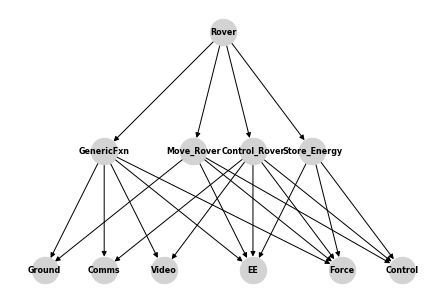

In [10]:
mdl = Rover()
rd.graph.show(mdl, gtype='typegraph')

As shown, because the class for `View Ground` and `Communicate Externally` are undefined, they are shown here as both instantiations of the `GenericFxn` class, which does not simulate. This same structure can also be visualized using:

In [11]:
fig_pyvis = rd.graph.show_pyvis(mdl.return_typegraph(), notebook=True)
fig_pyvis.show("structure.html")

While this view shows the containtment relationships of the *classes*, the bipartite graph view shows the instantiated connections between flows and objects. As shown:

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2c8973ec748>)

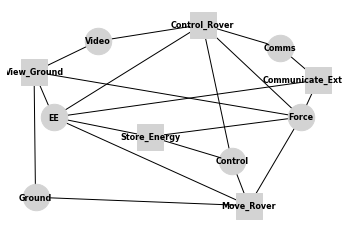

In [12]:
rd.graph.show(mdl, gtype="bipartite")

#### Run Order
To specify the run order of this model, the `add_fxn` method is used. The order of the call defines the run order of each instantiated function (`Control_Rover` -> `Move_Rover` -> `Store_Energy` ->  `View_Ground` -> `Communicate_Externally`).

In addition to the functions which have been defined here, this model additionally has a number of functions which have not been defined (and will thus not execute). We can visualize using `rd.graph.exec_order`.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2c89848b5c8>)

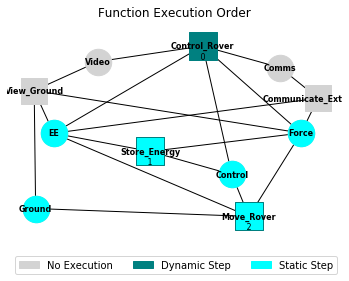

In [13]:
rd.graph.exec_order(mdl)

As shown, functions and flows active in the static propagation step are highlighted in cyan while the functions in the dynamic propagation step are shown (or given a border) in teal. Functions without behaviors are shown in light grey, and the run order of the dynamic propagation step is shown as numbers under the corresponding functions.

In addition, `rd.plot.dyn_order` can be used to visualize the dynamic propagation step.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2c8984d5208>)

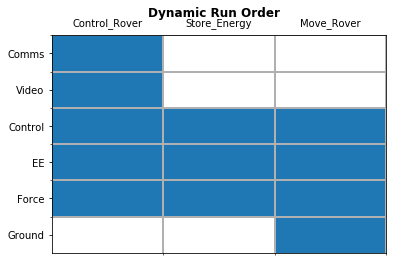

In [14]:
rd.plot.dyn_order(mdl)

This plot shows that the dynamic execution step runs in the order defined in the `Model` module: first, Control_Rover, then, Store_Energy, and finally Move_Rover (reading left-to-right in the upper axis). The plot additionally shows which flows correspond to these function as it progresses through execution, which enables some understanding of which data structures are used or acted on at each execution time. 

To verify the static propagation of the `short` mode in the `Move_Rover` function, we can view the results of that scenario. As was set up, the intention of using the static propagation step was to enable the resulting fault behavior (a spike in current followed by a loss of charge) to occur in a single timestep.

In [15]:
endresults, resgraph, mdlhist = prop.one_fault(mdl, "Move_Rover", "short", 10)

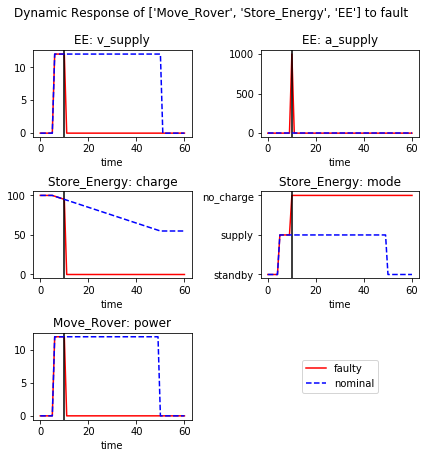

In [16]:
rd.plot.mdlhistvals(mdlhist, fxnflowvals={'Move_Rover':'power', 'Store_Energy':['mode', 'charge'], 'EE':['v_supply', 'a_supply']}, time=10)

As shown, the static propagation step enables the mode to propagate back to the `Store_Energy` function (causing the `no_charge` fault) in the same timestep it is injected, even though it occurs later in the propagation order. 

However, because the voltage and current output behaviors for the function are defined in the `dynamic_behavior` method of the `Store_Energy` function, these are only updated to their final value (of zero) at the next step. While this enables some visualization of the current spike, it may keep faults and behaviors from further propagating through the functions as desired. Thus, to enable this, one might reallocate some of the behaviors from the `dynamic_behavior` method to the `static_behavior` method.